# section 1

In [27]:
import sys
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install matplotlib.pyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
df22 = pd.read_csv(r'C:\Users\rafae\OneDrive\Documentos\prog\coding\modelagem-estatistica\MICRODADOS_ENEM_2022.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
                                                                                                                          "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
                                                                                                                          "NO_MUNICIPIO_PROVA","SG_UF_PROVA",
                                                                                                                          "NU_NOTA_COMP3",
                                                                                                                          "Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025"]).dropna()

In [29]:
# # computador fgv
# df22 = pd.read_csv(r'\Users\b47244\Documents\Nova pasta\MICRODADOS_ENEM_2022.csv',  sep=';',encoding='iso-8859-1', usecols=["NU_ANO","TP_FAIXA_ETARIA","TP_SEXO",
#                                                                                                                           "TP_COR_RACA","TP_ST_CONCLUSAO", 'TP_ANO_CONCLUIU', "TP_ESCOLA",
#                                                                                                                           "NO_MUNICIPIO_PROVA","SG_UF_PROVA",
#                                                                                                                           "NU_NOTA_COMP3",
#                                                                                                                           "Q001","Q002","Q003","Q004","Q005","Q006","Q022","Q025"]).dropna()

Agora, iremos tratar esses dados:

In [30]:
# apenas quem nao zerou a competencia 3
df22 = df22[df22['NU_NOTA_COMP3']!=0]

In [31]:
# Masculino = 1 e Feminino = 0
df22['TP_SEXO'] = df22['TP_SEXO'].replace('M',1).replace('F',0)

C:\Users\rafae\AppData\Local\Temp\ipykernel_23916\1660209483.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df22['TP_SEXO'] = df22['TP_SEXO'].replace('M',1).replace('F',0)


In [32]:
# apenas quem declarou a etnia e criar dummies
df22 = df22[df22['TP_COR_RACA']!=0]
df22 = pd.get_dummies(df22, columns=['TP_COR_RACA'], prefix='TP_COR_RACA')

In [33]:
# Ao invés de usar o nome dos municipios, iremos verificar se o aluno fez a prova em uma capital
capitais = [
    'Rio Branco', 'Maceió', 'Macapá', 'Manaus', 'Salvador', 'Fortaleza', 
    'Brasília', 'Vitória', 'Goiânia', 'São Luís', 'Cuiabá', 'Campo Grande', 
    'Belo Horizonte', 'Belém', 'João Pessoa', 'Curitiba', 'Recife', 
    'Teresina', 'Rio de Janeiro', 'Natal', 'Porto Alegre', 'Porto Velho', 
    'Boa Vista', 'Florianópolis', 'São Paulo', 'Aracaju', 'Palmas'
]

df22['CAPITAL'] = df22['NO_MUNICIPIO_PROVA'].apply(lambda x: 1 if x in capitais else 0)
df22 = df22.drop('NO_MUNICIPIO_PROVA',axis=1)

In [34]:
# %%script false
# iremos usar dummies das regiões do país ao inves do nome dos estados para diminuir o numero de variaveis no modelo

regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['GO', 'MT', 'MS', 'DF'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

def mapear_regiao(uf):
    for regiao, ufs in regioes.items():
        if uf in ufs:
            return regiao
    return None
df22['Regiao'] = df22['SG_UF_PROVA'].apply(mapear_regiao)

df22 = df22.drop('SG_UF_PROVA',axis=1)
df22 = pd.get_dummies(df22, columns=['Regiao'], prefix='Regiao')

In [35]:
# Q005 é sobre quantas pessoas moram na família e Q006 é sobre a renda mensal da familia (soma de cada um dos membros).
# Criaremos uma coluna que contabilize a renda per capita familiar

# Dicionário com as faixas salariais e seus valores numéricos
faixas_salarial = {
    'A': 0,
    'B': 1212,
    'C': 1818,
    'D': 2424,
    'E': 3030,
    'F': 3636,
    'G': 4848,
    'H': 6060,
    'I': 7272,
    'J': 8484,
    'K': 9696,
    'L': 10908,
    'M': 12120,
    'N': 14544,
    'O': 18180,
    'P': 24240,
    'Q': 24241  # Considerando acima de 24240
}

nova_faixa = {
    1: 0,
    2: 303,
    3: 606,
    4: 909,
    5: 1212,
    6: 1818,
    7: 2424,
    8: 3030,
    9: 3636,
    10: 4848,
    11: 6060,
    12: 9090,
    13: 9091, # valores acima de 9091 por pessoa
}

# Função para calcular a renda por pessoa e encontrar a faixa salarial correspondente
def calcular_faixa_renda_por_pessoa(pessoas, renda_familia):
    renda_total = faixas_salarial[renda_familia]
    renda_por_pessoa = renda_total / pessoas
    
    # Encontrar a faixa salarial correspondente
    for faixa, valor in nova_faixa.items():
        if renda_por_pessoa <= valor:
            return faixa
    return 13  # Para renda acima de R$ 9091,00 por pessoa

# Aplicar a função para calcular a faixa salarial da renda por pessoa
df22['faixa_per_capita_fam'] = df22.apply(lambda row: calcular_faixa_renda_por_pessoa(row['Q005'], row['Q006']), axis=1)

df22 = df22.drop('Q005',axis=1)
df22 = df22.drop('Q006',axis=1)


In [36]:
print(df22)
print(df22.iloc[:,[15,16,17,18,19]].sum())
print(df22['Q001'].value_counts())
print(df22['Q002'].value_counts())

         NU_ANO  TP_FAIXA_ETARIA  TP_SEXO  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  \
2          2022                5        0                1                2   
3          2022                6        1                1                2   
7          2022                6        0                1                0   
9          2022                4        0                1                1   
11         2022                2        0                2                0   
...         ...              ...      ...              ...              ...   
3476095    2022               12        1                1                7   
3476097    2022               11        0                1               11   
3476098    2022                2        1                2                0   
3476099    2022               11        0                1               11   
3476102    2022                2        1                2                0   

         TP_ESCOLA  NU_NOTA_COMP3 Q001 Q002 Q003  .

In [37]:
# apenas quem sabe a escolaridade do pai OU da mãe
df22 = df22.loc[(df22['Q001'] != 'H') | (df22['Q002'] != 'H')]

# apenas quem sabe a profissão do pai OU da mãe
df22 = df22[~((df22['Q003'] == 'F') & (df22['Q004'] == 'F'))]

# Aplicar a função de conversão apenas para as colunas com letras
def letra_num(letra):
    return ord(letra) - ord('A')

for col in ['Q001', 'Q002', 'Q003', 'Q004', 'Q022', 'Q025']:
    df22[col] = df22[col].apply(letra_num)

# substituimos os valores de quem não sabe para não alterar o max
df22[['Q001', 'Q002']] = df22[['Q001', 'Q002']].replace(7,-1)
df22[['Q003', 'Q004']] = df22[['Q003', 'Q004']].replace(5,-1)

# escolhemos o responsável com maior escolaridade e o com "maior emprego"
df22['responsavel_maior_escolaridade'] = df22[['Q001', 'Q002']].max(axis=1)
df22['responsavel_maior_emprego'] = df22[['Q003', 'Q004']].max(axis=1)

df22= df22.drop(['Q001', 'Q002', 'Q003', 'Q004'],axis=1)


In [38]:
print(df22)
print(df22.iloc[:,[15,16,17,18,19]].sum())
print(df22['Q001'].value_counts())
print(df22['Q002'].value_counts())
print(df22['responsavel_maior_emprego'].value_counts())
print(df22['responsavel_maior_escolaridade'].value_counts())
# nao pode ter 6 ou 7 (depende)

         NU_ANO  TP_FAIXA_ETARIA  TP_SEXO  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  \
2          2022                5        0                1                2   
3          2022                6        1                1                2   
7          2022                6        0                1                0   
9          2022                4        0                1                1   
11         2022                2        0                2                0   
...         ...              ...      ...              ...              ...   
3476095    2022               12        1                1                7   
3476097    2022               11        0                1               11   
3476098    2022                2        1                2                0   
3476099    2022               11        0                1               11   
3476102    2022                2        1                2                0   

         TP_ESCOLA  NU_NOTA_COMP3  Q001  Q002  Q003

# section 2

Analisando os dados, percebi que apenas quem irá concluir o EM em 2022 que informou o tipo de escola que estudou (pública ou privada). Por isso, criei um segundo dataframe para analisar apenas esse grupo. No primeiro dataframe analiasaremos os dois grupos e poderemos ver como o ano de conclusão influencia no nota final.

In [39]:
# Apenas quem irá concluir o EM no ano da prova que informou o tipo de escola. 
# Por isso nesse df analisaremos o impacto do tipo de escola na nota final.
# pública = 0 e privada = 1
df22_2 = df22.copy()
df22_2 = df22[df22['TP_ST_CONCLUSAO']==2]
df22_2.loc[:, 'TP_ESCOLA'] = df22['TP_ESCOLA'] - 2

In [40]:
# Pessoas que já se formaram nao identificaram o tipo de escola que estudaram (se publica ou privada).
# Logo criamos um df para podermos verificar se a quantidade de tempo desde que ela concluiu o EM influenciou no seu resultado

df22 = df22[(df22['TP_ST_CONCLUSAO'] == 1) | (df22['TP_ST_CONCLUSAO'] == 2)]

# excluimos quem já concluiu o EM e não informou o ano que concluiu o EM
df22 = df22.drop(df22[(df22['TP_ST_CONCLUSAO'] == 1) & (df22['TP_ANO_CONCLUIU'] == 0)].index)

In [41]:
# removemos a coluna do status de conclusao no DFs 1 e 2
df22 = df22.drop('TP_ST_CONCLUSAO',axis=1)
df22_2 = df22_2.drop('TP_ST_CONCLUSAO',axis=1)

In [42]:
# removemos a coluna de ano de conclusão do DF 2
df22_2 = df22_2.drop('TP_ANO_CONCLUIU',axis=1)

In [43]:
# removemos a coluna do tipo de escola do DF 1
df22 = df22.drop('TP_ESCOLA',axis=1)


In [44]:
# Reiniciar os índices
df22.reset_index(drop=True, inplace=True)
df22_2.reset_index(drop=True, inplace=True)

# trocar booleanos
df22 = df22.astype(int)
df22_2 = df22_2.astype(int)

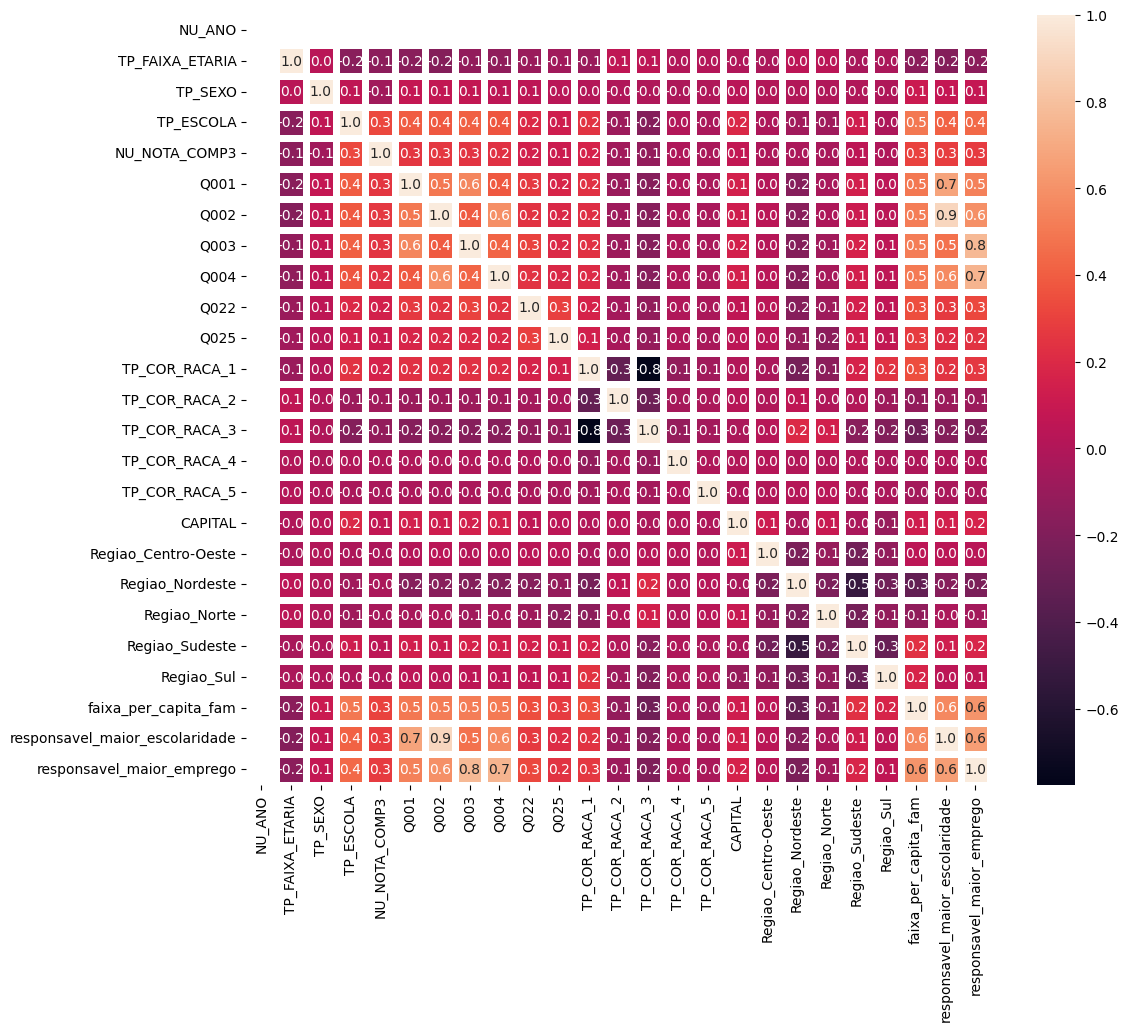

In [45]:
# Aumente o tamanho da figura
plt.figure(figsize=(12, 10))

# plot da matriz de correlação
# plot = sns.heatmap(df22.corr(method='spearman'), annot = True, fmt="0.1f", linewidths=5)
# fig = plot.get_figure()

plot = sns.heatmap(df22_2.corr(method='spearman'), annot = True, fmt="0.1f", linewidths=5)
fig = plot.get_figure()

In [46]:
import pandas as pd
!{sys.executable} -m pip install sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supondo que você tenha um DataFrame chamado df com as suas variáveis independentes e dependentes

# Separar as variáveis independentes (X) da variável dependente (y)
X = df22[['variavel_independente_1', 'variavel_independente_2', ...]]
y = df22['variavel_dependente']

# Dividir o conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o modelo de regressão linear
modelo_regressao = LinearRegression()

# Treinar o modelo com os dados de treinamento
modelo_regressao.fit(X_train, y_train)

# Avaliar o modelo utilizando os dados de teste
score = modelo_regressao.score(X_test, y_test)

# Coeficientes da regressão
coeficientes = modelo_regressao.coef_

# Intercepto da regressão
intercepto = modelo_regressao.intercept_

# Imprimir os coeficientes
print("Coeficientes da regressão:")
for i, coeficiente in enumerate(coeficientes):
    print(f"Coeficiente {i+1}: {coeficiente}")

# Imprimir o intercepto
print("Intercepto da regressão:", intercepto)


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

ModuleNotFoundError: No module named 'sklearn'